In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, ttest_ind
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Loading

In [2]:
csv_directory = '../data/noise_measures'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through the files and read them into pandas
for file in csv_files:
    file_path = os.path.join(csv_directory, file)
    df = pd.read_csv(file_path)  # Adjust the delimiter if needed, e.g., sep=";"
    dataframes.append(df)

# Concatenate all DataFrames
df_noise = pd.concat(dataframes, ignore_index=True)

df_noise.head()

,Any,Mes,Dia,Hora,Id_Instal,Nivell_LAeq_1h
0,2015,3,19,0:00,391,66.9
1,2015,3,19,1:00,391,64.5
2,2015,3,19,2:00,391,62.1
3,2015,3,19,3:00,391,61.9
4,2015,3,19,4:00,391,61.0


In [3]:
# Include location of sensors
df_sensors = pd.read_csv('../data/XarxaSoroll_EquipsMonitor_Instal.csv')

df_noise = df_noise.merge(df_sensors[['Id_Instal', 'Latitud', 'Longitud']], on='Id_Instal', how='left')
df_noise.head(5)

,Any,Mes,Dia,Hora,Id_Instal,Nivell_LAeq_1h,Latitud,Longitud
0,2015,3,19,0:00,391,66.9,41.402959,2.137835
1,2015,3,19,1:00,391,64.5,41.402959,2.137835
2,2015,3,19,2:00,391,62.1,41.402959,2.137835
3,2015,3,19,3:00,391,61.9,41.402959,2.137835
4,2015,3,19,4:00,391,61.0,41.402959,2.137835


In [4]:
# Combine the date and time columns into a single DateTimeIndex
df_noise["Datetime"] = pd.to_datetime(df_noise[["Any", "Mes", "Dia"]].astype(str).agg('-'.join, axis=1) + " " + df_noise["Hora"])
df_noise.set_index("Datetime", inplace=True)

# Drop the original columns used to create the DateTimeIndex
df_noise.drop(columns=["Any", "Mes", "Dia", "Hora"], inplace=True)

# Change name of Noise db data
df_noise.rename(columns={'Nivell_LAeq_1h':'Noise_db'}, inplace=True)

# Sort dataframe by index
df_noise.sort_index(inplace=True)
df_noise.head()

,Id_Instal,Noise_db,Latitud,Longitud
Datetime,,,,
2015-01-01 07:00:00,186,74.3,41.395450,2.152753
2015-01-01 07:00:00,187,68.6,41.396156,2.151564
2015-01-01 08:00:00,186,67.4,41.395450,2.152753
2015-01-01 08:00:00,187,65.0,41.396156,2.151564
2015-01-01 09:00:00,186,63.2,41.395450,2.152753


# Time Series of a Sensor

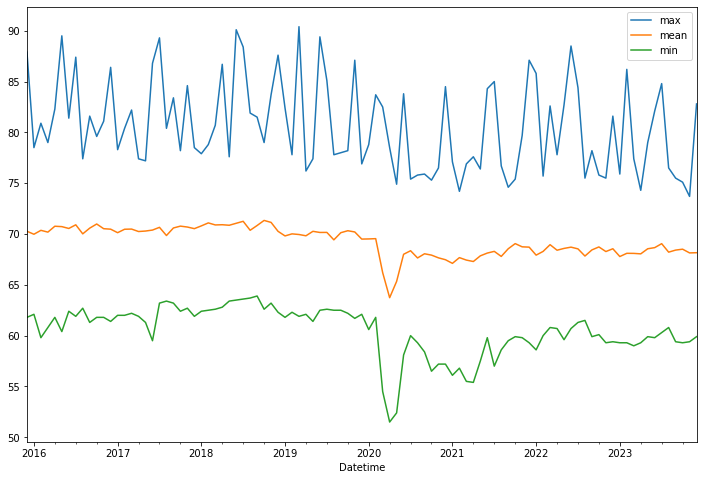

In [5]:
# Select sensor with more samples
max_sensor_id = df_noise.groupby('Id_Instal')['Id_Instal'].value_counts().sort_values(ascending=False).reset_index().iloc[0][0]

# Get the dataframe of a sensor
df_sensor = df_noise[df_noise['Id_Instal'] == max_sensor_id]

sensor_samples_max = df_sensor['Noise_db'].resample('ME').max()
sensor_samples_mean = df_sensor['Noise_db'].resample('ME').mean()
sensor_samples_min = df_sensor['Noise_db'].resample('ME').min()

# Plot the sensor values
plt.figure(figsize=(12,8))
sensor_samples_max.plot(label='max')
sensor_samples_mean.plot(label='mean')
sensor_samples_min.plot(label='min')
plt.legend()
plt.plot();

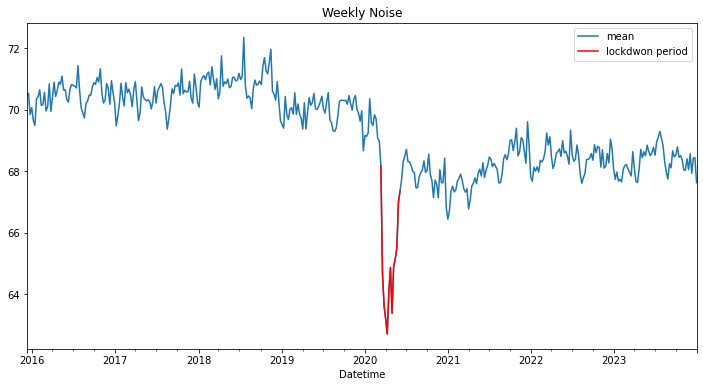

In [6]:
sensor_samples_mean = df_sensor['Noise_db'].resample('w').mean()

lockdown_start = '2020-03-14'
lockdown_end = '2020-06-07'

lockdown_data = sensor_samples_mean[
    (sensor_samples_mean.index >= lockdown_start) &
    (sensor_samples_mean.index <= lockdown_end)
]


plt.figure(figsize=(12,6))
sensor_samples_mean.plot(label='mean')
lockdown_data.plot(label='lockdwon period', color='red')
plt.title('Weekly Noise')
plt.legend()
plt.plot();

## Missing values of sensor

In [7]:
# Let's check for missing values between the dates of the sensor
start_date = df_sensor.index.min()
end_date = df_sensor.index.max()
full_data_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Check for missing data
missing_data = full_data_range[~full_data_range.isin(df_sensor.index)]
missing_data

# Add the missing dates to the index
df_sensor = df_sensor.reindex(full_data_range)

# Check for missing data
missing_index = df_sensor[df_sensor['Noise_db'].isna()].index.tolist()

df_sensor.isna().sum()

Id_Instal    1400
Noise_db     1400
Latitud      1400
Longitud     1400
dtype: int64

Let's use a RandomForest model to predict the values missing

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Feature engineering from df_sensor
df_sensor['hour'] = df_sensor.index.hour
df_sensor['day_of_week'] = df_sensor.index.dayofweek
df_sensor['month'] = df_sensor.index.month

# Split the data
train_data = df_sensor.dropna(subset=['Noise_db'])
missing_data = df_sensor[df_sensor['Noise_db'].isna()]

X_train = train_data[['hour', 'day_of_week', 'month']]
y_train = train_data['Noise_db']
X_missing = missing_data[['hour', 'day_of_week', 'month']]

# Train the model
model = RandomForestRegressor(random_state=23, n_estimators=100)
model.fit(X_train, y_train)

# Predict missing values
predicted_values = model.predict(X_missing)

# Evaluate the model
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=23
)
model.fit(X_train_split, y_train_split)
y_pred = model.predict(X_test_split)
mse = mean_squared_error(y_test_split, y_pred)

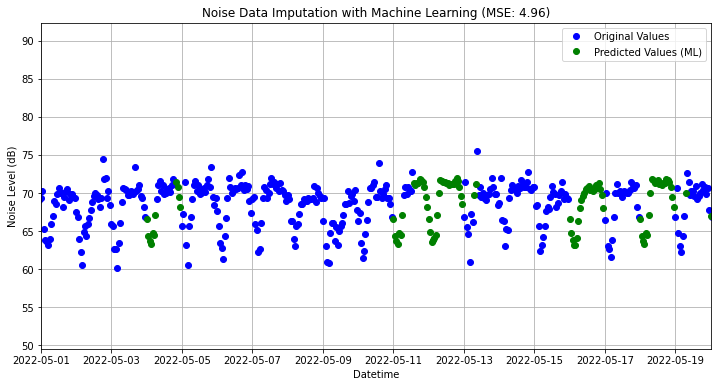

In [9]:

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Noise_db'], 'o', label='Original Values', color='blue')
plt.plot(missing_data.index, predicted_values, 'o', label='Predicted Values (ML)', color='green')
plt.title(f'Noise Data Imputation with Machine Learning (MSE: {mse:.2f})')
plt.xlabel('Datetime')
plt.ylabel('Noise Level (dB)')
plt.legend()
plt.grid(True)
plt.xlim(pd.to_datetime('2022-05-01'), pd.to_datetime('2022-05-20'))
plt.show()

Fill in all the remaining data in the new indexes

In [10]:
# Fill in missing values
df_sensor.loc[df_sensor['Noise_db'].isna(), 'Noise_db'] = predicted_values

In [11]:
df_sensor['Latitud'] = df_sensor['Latitud'].fillna(df_sensor['Latitud'][0])
df_sensor['Longitud'] = df_sensor['Longitud'].fillna(df_sensor['Longitud'][0])
df_sensor['Id_Instal'] = df_sensor['Id_Instal'].fillna(df_sensor['Id_Instal'][0])

df_sensor.isna().sum()

Id_Instal      0
Noise_db       0
Latitud        0
Longitud       0
hour           0
day_of_week    0
month          0
dtype: int64

## EDA

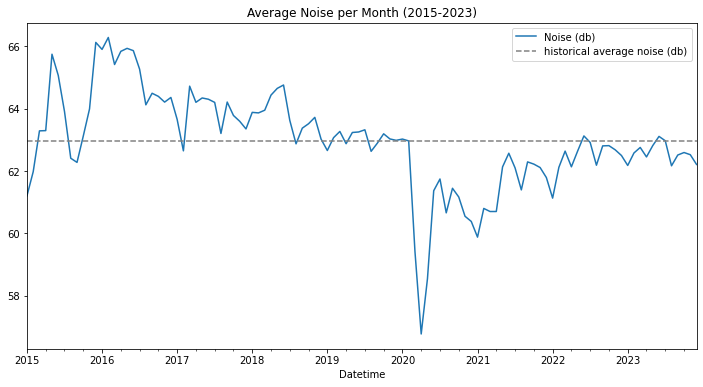

In [12]:
# Mean noise per month
noise_month_year = df_noise['Noise_db'].resample('MS').mean()

# Total sensors per month
sensor_per_month = df_noise['Id_Instal'].resample('MS').sum()

plt.figure(figsize=(12,6))
noise_month_year.plot(label='Noise (db)')
plt.title('Average Noise per Month (2015-2023)')
plt.axhline(np.mean(noise_month_year), linestyle='--', color='grey', label='historical average noise (db)')
plt.legend()
plt.show()

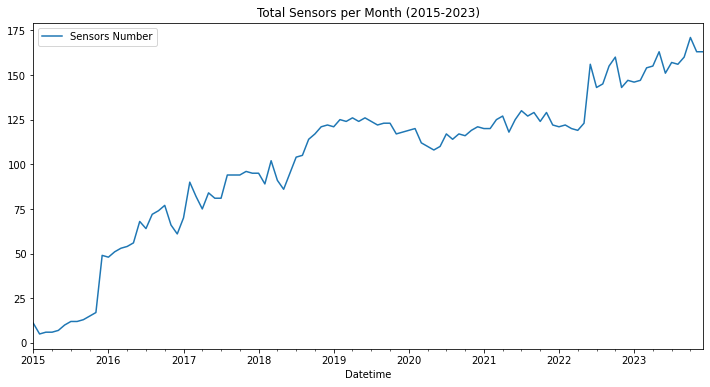

In [13]:
sensor_per_month = df_noise['Id_Instal'].resample('MS').nunique()

plt.figure(figsize=(12,6))
sensor_per_month.plot(label='Sensors Number')
plt.title('Total Sensors per Month (2015-2023)')
plt.legend()
plt.show()

<Axes: xlabel='Noise_db', ylabel='Count'>

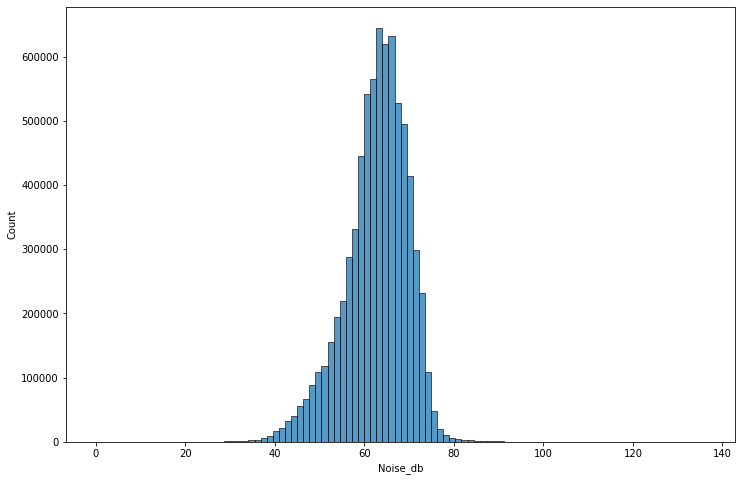

In [14]:
# Let's plot the noise distribution

plt.figure(figsize=(12,8))
sns.histplot(df_noise['Noise_db'], bins=100)

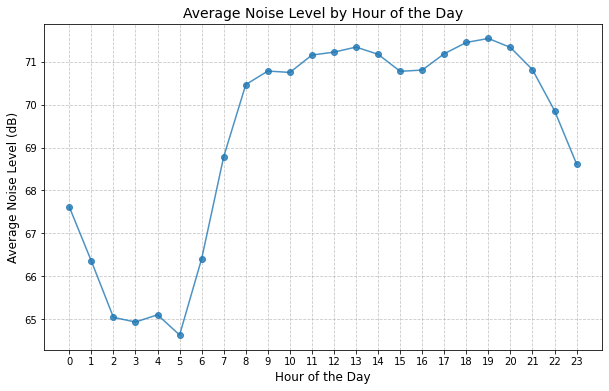

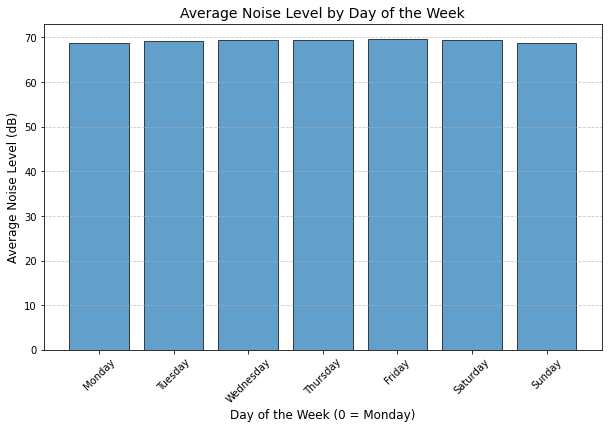

In [15]:
# Calculate average noise level by hour of the day
hourly_avg = df_sensor.groupby('hour')['Noise_db'].mean()

# Visualize average noise level by hour of the day
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linestyle='-', alpha=0.8)
plt.title('Average Noise Level by Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Noise Level (dB)', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

# Calculate average noise level by day of the week
weekday_avg = df_sensor.groupby('day_of_week')['Noise_db'].mean()

# Visualize average noise level by day of the week
plt.figure(figsize=(10, 6))
plt.bar(weekday_avg.index, weekday_avg.values, alpha=0.7, edgecolor='k')
plt.title('Average Noise Level by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week (0 = Monday)', fontsize=12)
plt.ylabel('Average Noise Level (dB)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(
    range(7),
    labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    rotation=45
)
plt.show()

# Lockdown Impact

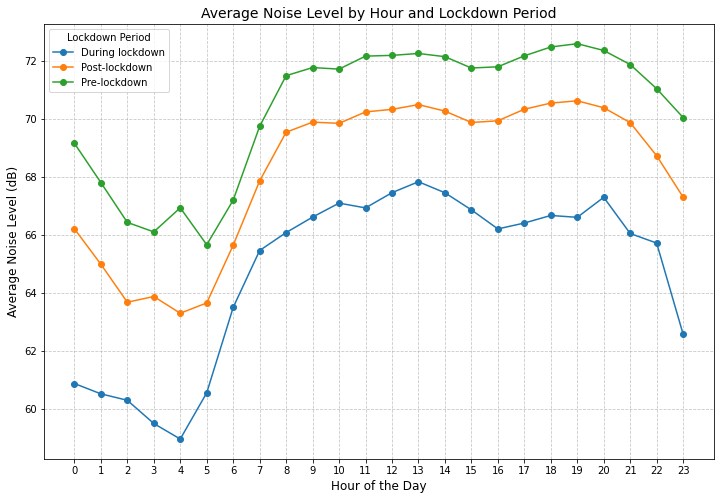

In [16]:
lockdown_start = '2020-03-14'
lockdown_end = '2020-06-07'

# Categorical values for pre, during and post lockdown periods
df_sensor['Lockdown'] = np.where(
    df_sensor.index < pd.to_datetime(lockdown_start), 'Pre-lockdown',
    np.where(
        df_sensor.index <= pd.to_datetime(lockdown_end), 'During lockdown', 'Post-lockdown'
    )
)

# Calculate the hourly average noise levels by lockdown period
avg_hourly_lockdown = df_sensor.groupby(['Lockdown', 'hour'])['Noise_db'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))

# Plot each lockdown period with a unique color
for period in avg_hourly_lockdown['Lockdown'].unique():
    subset = avg_hourly_lockdown[avg_hourly_lockdown['Lockdown'] == period]
    plt.plot(
        subset['hour'],
        subset['Noise_db'],
        marker='o',
        linestyle='-',
        label=period
    )

# Customize the plot
plt.title('Average Noise Level by Hour and Lockdown Period', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Noise Level (dB)', fontsize=12)
plt.xticks(range(24))
plt.legend(title='Lockdown Period')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

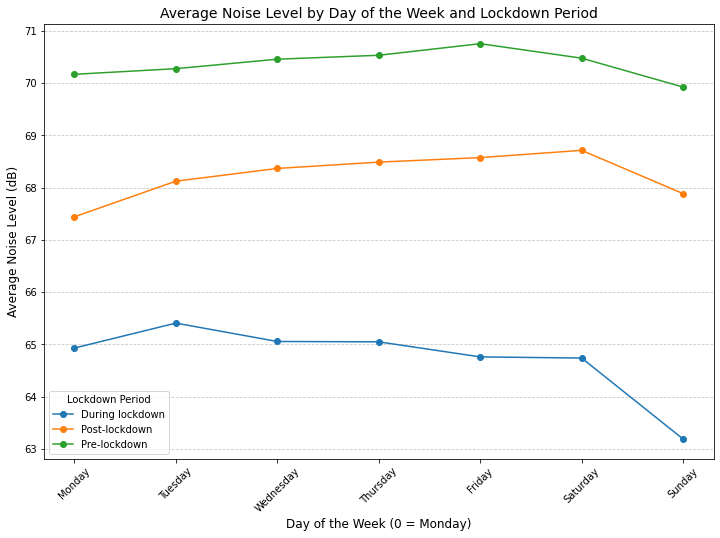

In [17]:
# Calculate average noise levels by day of the week for each lockdown period
weekday_avg_lockdown = df_sensor.groupby(['Lockdown', 'day_of_week'])['Noise_db'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))

# Plot each lockdown period with a unique color
for period in weekday_avg_lockdown['Lockdown'].unique():
    subset = weekday_avg_lockdown[weekday_avg_lockdown['Lockdown'] == period]
    plt.plot(
        subset['day_of_week'],
        subset['Noise_db'],
        marker='o',
        linestyle='-',
        label=period
    )

# Customize the plot
plt.title('Average Noise Level by Day of the Week and Lockdown Period', fontsize=14)
plt.xlabel('Day of the Week (0 = Monday)', fontsize=12)
plt.ylabel('Average Noise Level (dB)', fontsize=12)
plt.xticks(
    range(7),
    labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    rotation=45
)
plt.legend(title='Lockdown Period')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Forecasting

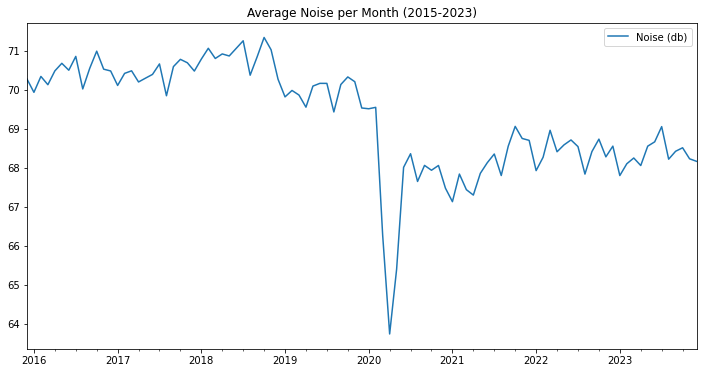

In [18]:
# Mean noise per month
sensor_avg_noise = df_sensor['Noise_db'].resample('MS').mean()

plt.figure(figsize=(12,6))
sensor_avg_noise.plot(label='Noise (db)')
plt.title('Average Noise per Month (2015-2023)')
plt.legend()
plt.show()

## Check for Stationarity: ADF Test

In [19]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_sensor['Noise_db'])

# Results of ADF test
adf_results = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4]
}
adf_results

{'ADF Statistic': -11.818452949866787,
 'p-value': 8.526641407557086e-22,
 'Critical Values': {'1%': -3.430442533641834,
  '5%': -2.8615808982329436,
  '10%': -2.5667917687308552}}

* The ADF Statistic is less then the critical value at 5%.
* P-value is less than 0.05

We reject the null hypothesis (H0). The series is stationary!

# Seasonal Decompose

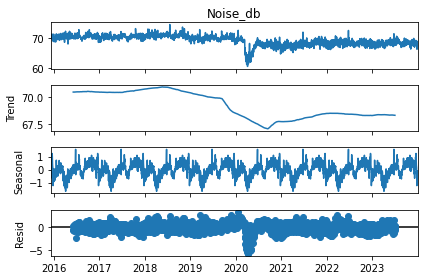

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
result = seasonal_decompose(df_sensor['Noise_db'].resample('d').mean().fillna(df_sensor['Noise_db'].mean()), model='additive', period=365)

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

# Seasonal ARIMA (SARIMAX)

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Step 3.1: Split the data into training and testing sets
train_size = int(len(df_sensor) * 0.8)
train, test = df_sensor[:train_size], df_sensor[train_size:]

# Step 3.2: Fit a SARIMA model
# Using seasonal order for hourly seasonality (24-hour cycle)
sarima_model = SARIMAX(train['Noise_db'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))

sarima_fit = sarima_model.fit(disp=False)

# Step 3.3: Evaluate the model on the test set
predictions = sarima_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
rmse = np.sqrt(mean_squared_error(test['Noise_db'], predictions))

# Step 3.4: Forecast future values (next 24 hours)
forecast_horizon = 24
forecast = sarima_fit.get_forecast(steps=forecast_horizon)
forecast_values = forecast.predicted_mean

# Results
model_results = {
    "RMSE on Test Set": rmse,
    "Forecasted Values": forecast_values
}
model_results

{'RMSE on Test Set': 2.0886625911498937,
 'Forecasted Values': 2022-05-21 14:00:00    70.728306
 2022-05-21 15:00:00    70.332447
 2022-05-21 16:00:00    70.393483
 2022-05-21 17:00:00    70.823346
 2022-05-21 18:00:00    71.360911
 2022-05-21 19:00:00    71.504387
 2022-05-21 20:00:00    70.965592
 2022-05-21 21:00:00    70.344848
 2022-05-21 22:00:00    69.585829
 2022-05-21 23:00:00    68.672089
 2022-05-22 00:00:00    67.568253
 2022-05-22 01:00:00    67.666542
 2022-05-22 02:00:00    65.353566
 2022-05-22 03:00:00    64.638245
 2022-05-22 04:00:00    63.293753
 2022-05-22 05:00:00    64.799210
 2022-05-22 06:00:00    66.530615
 2022-05-22 07:00:00    68.769460
 2022-05-22 08:00:00    70.278146
 2022-05-22 09:00:00    70.581508
 2022-05-22 10:00:00    70.031491
 2022-05-22 11:00:00    70.542954
 2022-05-22 12:00:00    70.465027
 2022-05-22 13:00:00    70.625891
 Freq: h, Name: predicted_mean, dtype: float64}

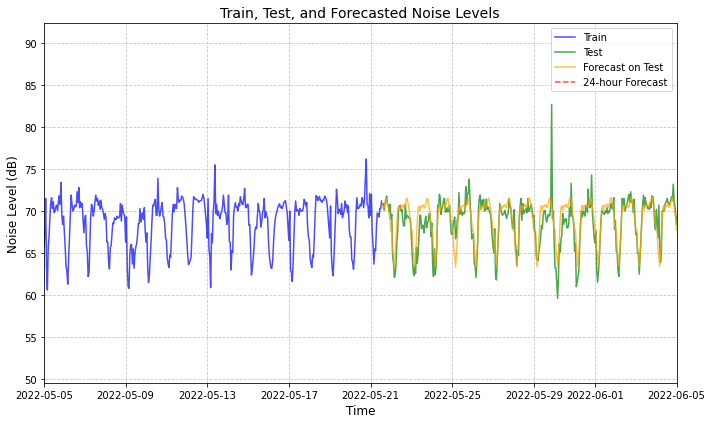

In [22]:
# Plot the train, test, and forecast values on the same graph
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train.index, train['Noise_db'], label='Train', color='blue', alpha=0.7)

# Plot the testing data
plt.plot(test.index, test['Noise_db'], label='Test', color='green', alpha=0.7)

# Plot the forecasted values for the test set
plt.plot(test.index, predictions, label='Forecast on Test', color='orange', alpha=0.7)

# Plot the 24-hour forecast
forecast_index = pd.date_range(start=test.index[-1], periods=24, freq='H')
plt.plot(forecast_index, forecast_values, label='24-hour Forecast', color='red', linestyle='--', alpha=0.7)

# Customize the plot
plt.title('Train, Test, and Forecasted Noise Levels', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Noise Level (dB)', fontsize=12)
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xlim(pd.to_datetime('2022-05-05'), pd.to_datetime('2022-06-05'))
plt.tight_layout()
plt.show()

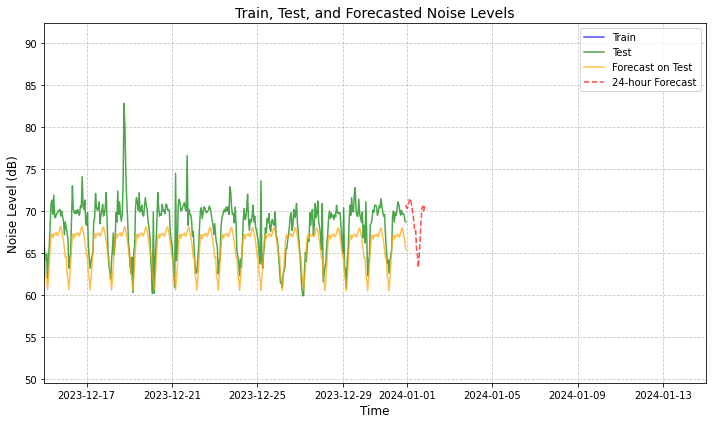

In [23]:
# Plot the train, test, and forecast values on the same graph
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train.index, train['Noise_db'], label='Train', color='blue', alpha=0.7)

# Plot the testing data
plt.plot(test.index, test['Noise_db'], label='Test', color='green', alpha=0.7)

# Plot the forecasted values for the test set
plt.plot(test.index, predictions, label='Forecast on Test', color='orange', alpha=0.7)

# Plot the 24-hour forecast
forecast_index = pd.date_range(start=test.index[-1], periods=24, freq='H')
plt.plot(forecast_index, forecast_values, label='24-hour Forecast', color='red', linestyle='--', alpha=0.7)

# Customize the plot
plt.title('Train, Test, and Forecasted Noise Levels', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Noise Level (dB)', fontsize=12)
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xlim(pd.to_datetime('2023-12-15'), pd.to_datetime('2024-01-15'))
plt.tight_layout()
plt.show()

The forecast is not precise enough, as it tends to be lower than expected. This may be due to the "black swan" event caused by the lockdown. To improve accuracy, we could treat the Pre-lockdown, During-lockdown, and Post-lockdown periods independently.

For now, we are going to move on to Machine Learning models to handle the lockdown.

# Machine Learning Forecasting

In [24]:
df_sensor.head()

,Id_Instal,Noise_db,Latitud,Longitud,hour,day_of_week,month,Lockdown
2015-12-07 00:00:00,496.0,69.0,41.374878,2.161585,0,0,12,Pre-lockdown
2015-12-07 01:00:00,496.0,66.6,41.374878,2.161585,1,0,12,Pre-lockdown
2015-12-07 02:00:00,496.0,65.5,41.374878,2.161585,2,0,12,Pre-lockdown
2015-12-07 03:00:00,496.0,63.9,41.374878,2.161585,3,0,12,Pre-lockdown
2015-12-07 04:00:00,496.0,62.6,41.374878,2.161585,4,0,12,Pre-lockdown


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit


# One-hot-encoding for lockdown periods (categorical data to numerical)
df_sensor_encoded = pd.get_dummies(df_sensor, columns=['Lockdown'], prefix='lockdown')

# Prepare features (X) and target (y)
X = df_sensor_encoded.drop(columns=['Noise_db'])
y = df_sensor_encoded['Noise_db']

# Define the models to evaluate
model_definitions = {
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(max_depth=5, random_state=42)
}

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=3)

# Initialize lists to store results
all_results = []
all_predictions = []

# Iterate over each model
for model_name, model in model_definitions.items():
    print(f"Evaluating {model_name}...")
    fold_results = []
    predictions_list = []

    # Perform TimeSeriesSplit
    for fold, (train_index, test_index) in enumerate(tscv.split(X), start=1):
        # Split the data into train and test sets for the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model on the current fold
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics for the current fold
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store fold results
        fold_results.append({"Model": model_name, "Fold": fold, "RMSE": rmse, "MAPE": mape, "R2": r2})

        # Save predictions
        fold_predictions = pd.DataFrame({
            "Model": model_name,
            "Fold": fold,
            "Actual": y_test,
            "Predicted": y_pred
        })
        predictions_list.append(fold_predictions)

    # Aggregate results for this model
    all_results.extend(fold_results)
    all_predictions.extend(predictions_list)

# Create a DataFrame for all results
all_results_df = pd.DataFrame(all_results)

# Ensure each DataFrame in `all_predictions` has a datetime index before concatenating
for df in all_predictions:
    if 'Timestamp' in df.columns:  # Replace 'Timestamp' with the column representing datetime
        df.set_index('Timestamp', inplace=True)

# Combine all predictions into a single DataFrame
all_predictions_df = pd.concat(all_predictions, ignore_index=False)

Evaluating Gradient Boosting Regressor...
Evaluating Random Forest Regressor...
Evaluating Linear Regression...
Evaluating Decision Tree Regressor...


In [26]:
all_results_df

,Model,Fold,RMSE,MAPE,R2
0,Gradient Boosting Regressor,1,1.654027,0.015913,0.663671
1,Gradient Boosting Regressor,2,3.591842,0.043383,0.058203
2,Gradient Boosting Regressor,3,1.884630,0.018436,0.596718
3,Random Forest Regressor,1,1.698912,0.016468,0.645169
4,Random Forest Regressor,2,3.618957,0.043646,0.043930
5,Random Forest Regressor,3,1.974486,0.019667,0.557345
6,Linear Regression,1,2.386851,0.026472,0.299626
7,Linear Regression,2,4.108679,0.047492,-0.232331
8,Linear Regression,3,2.459013,0.028679,0.313440
9,Decision Tree Regressor,1,1.705084,0.016592,0.642587


**Gradient Boosting Regressor** is the model that best perfomed:
* It consistently outperforms others with the lowest RMSE, MAPE and R2 across most folds.
* It is robust for time series data due to its ability to handle non-linear relationships effectively.
* The fold 2 shows a poor performance through all models. This is due to the fold 2 covers the lockdown period. We'll need to handle it later.

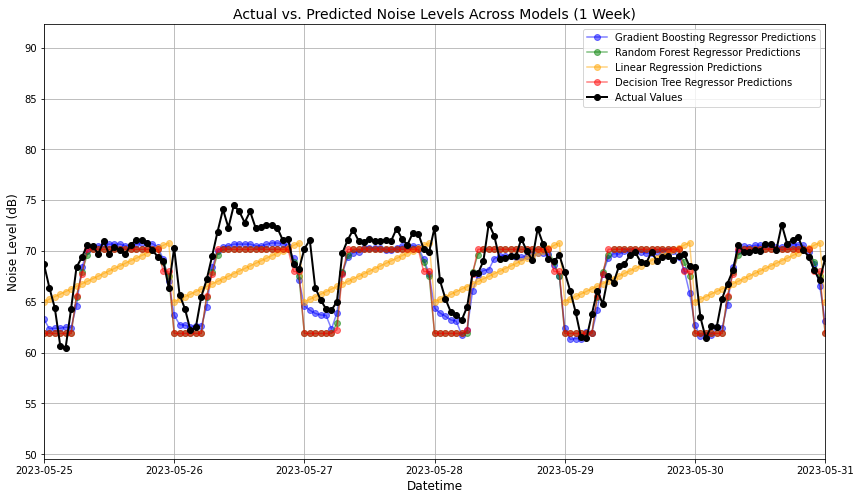

In [27]:
# Define consistent colors for each model
model_colors = {
    "Gradient Boosting Regressor": "blue",
    "Random Forest Regressor": "green",
    "Linear Regression": "orange",
    "Decision Tree Regressor": "red",
    "Actual": "black"
}

plt.figure(figsize=(14, 8))

# Plot predictions for each model
for model_name in all_predictions_df['Model'].unique():
    model_subset = all_predictions_df[all_predictions_df['Model'] == model_name]
    plt.plot(
        model_subset.index,
        model_subset['Predicted'],
        marker='o',
        alpha=0.5,
        linestyle='-',
        label=f"{model_name} Predictions",
        color=model_colors[model_name]
    )

# Plot actual values (these are shared across all models for each fold)
actual_values = all_predictions_df.groupby(all_predictions_df.index)['Actual'].first()  # Ensures only unique actual values
plt.plot(
    actual_values.index,
    actual_values,
    marker='o',
    linestyle='-',
    label="Actual Values",
    color=model_colors["Actual"],
    linewidth=2
)

# Customize the plot
plt.title("Actual vs. Predicted Noise Levels Across Models (1 Week)", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Noise Level (dB)", fontsize=12)
plt.legend()
plt.grid()
plt.xlim(pd.to_datetime('2023-05-25'), pd.to_datetime('2023-05-31'))
plt.show()

In [29]:
df_sensor.head()

,Id_Instal,Noise_db,Latitud,Longitud,hour,day_of_week,month,Lockdown
2015-12-07 00:00:00,496.0,69.0,41.374878,2.161585,0,0,12,Pre-lockdown
2015-12-07 01:00:00,496.0,66.6,41.374878,2.161585,1,0,12,Pre-lockdown
2015-12-07 02:00:00,496.0,65.5,41.374878,2.161585,2,0,12,Pre-lockdown
2015-12-07 03:00:00,496.0,63.9,41.374878,2.161585,3,0,12,Pre-lockdown
2015-12-07 04:00:00,496.0,62.6,41.374878,2.161585,4,0,12,Pre-lockdown


# Different Models per Each Lockdown Period

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize a dictionary to store models and their metrics
model_results = {}

# Loop through each lockdown period
for period in df_sensor['Lockdown'].unique():
    print(f"Training model for {period} period...")
    
    # Filter data for the current period
    period_data = df_sensor[df_sensor['Lockdown'] == period]
    
    # Prepare features (X) and target (y)
    X_period = period_data[['hour', 'day_of_week', 'month']]
    y_period = period_data['Noise_db']
    
    # Train-test split
    train_size = int(len(X_period) * 0.8)
    X_train, X_test = X_period.iloc[:train_size], X_period.iloc[train_size:]
    y_train, y_test = y_period.iloc[:train_size], y_period.iloc[train_size:]
    
    # Train a Gradient Boosting Regressor
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Store results
    model_results[period] = {
        "Model": model,
        "Metrics": {"MSE": mse, "MAE": mae, "R2": r2}
    }
    print(f"Metrics for {period}: MSE={mse:.2f}, MAE={mae:.2f}, R2={r2:.2f}, MAPE={mape:.2f}\n")

Training model for Pre-lockdown period...
Metrics for Pre-lockdown: MSE=2.79, MAE=1.28, R2=0.64, MAPE=0.02

Training model for During lockdown period...
Metrics for During lockdown: MSE=8.77, MAE=2.29, R2=0.32, MAPE=0.03

Training model for Post-lockdown period...
Metrics for Post-lockdown: MSE=2.50, MAE=1.05, R2=0.72, MAPE=0.02



## Let's get rid of Lockdown data

In [33]:
# Filter out lockdown period data
filtered_data = df_sensor[(df_sensor.index < lockdown_start) | (df_sensor.index > lockdown_end)]

# Check the filtered data
print(f"Original data size: {df_sensor.shape[0]}")
print(f"Filtered data size: {filtered_data.shape[0]}")

Original data size: 70728
Filtered data size: 68687


In [44]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare features and target from filtered data
X_filtered = filtered_data[['hour', 'day_of_week', 'month']]
y_filtered = filtered_data['Noise_db']

# Train-test split
train_size = int(len(X_filtered) * 0.8)
X_train, X_test = X_filtered.iloc[:train_size], X_filtered.iloc[train_size:]
y_train, y_test = y_filtered.iloc[:train_size], y_filtered.iloc[train_size:]

# Train a Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Metrics without lockdown data: MSE={mse:.2f}, MAE={mae:.2f}, R2={r2:.2f}, MAPE={mape:.2f}")

Metrics without lockdown data: MSE=4.28, MAE=1.69, R2=0.52, MAPE=0.02


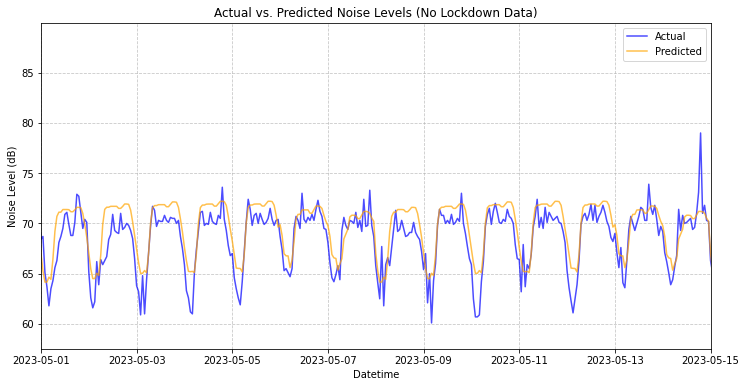

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', color='orange', alpha=0.7)
plt.title('Actual vs. Predicted Noise Levels (No Lockdown Data)')
plt.xlabel('Datetime')
plt.ylabel('Noise Level (dB)')
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xlim(pd.to_datetime('2023-05-01'), pd.to_datetime('2023-05-15'))
plt.show()

## Hyperparameter Tuning

### 1. GridSearch

In [48]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_model = GradientBoostingRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate the optimized model
y_pred_optimized = best_model.predict(X_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
mape_optimized = mean_absolute_percentage_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print("\nMetrics for the optimized model:")
print(f"- MSE: {mse_optimized:.2f}")
print(f"- MAE: {mae_optimized:.2f}")
print(f"- MAPE: {mape_optimized:.2%}")
print(f"- R2: {r2_optimized:.2f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

Metrics for the optimized model:
- MSE: 4.24
- MAE: 1.68
- MAPE: 2.49%
- R2: 0.52


### 2. Feature Engineering

In [55]:
# Create lag features
df_sensor['lag_1'] = df_sensor['Noise_db'].shift(1)
df_sensor['lag_24'] = df_sensor['Noise_db'].shift(24)

# Drop rows with NaN values introduced by lags
df_sensor = df_sensor.dropna()

# Public holidays
public_holidays = pd.DatetimeIndex([
    # 2015
    "2015-01-01", "2015-01-06", "2015-04-03", "2015-04-06", "2015-05-01", 
    "2015-06-24", "2015-08-15", "2015-09-11", "2015-09-24", "2015-10-12", 
    "2015-11-01", "2015-12-06", "2015-12-08", "2015-12-25",

    # 2016
    "2016-01-01", "2016-01-06", "2016-03-25", "2016-03-28", "2016-05-01", 
    "2016-05-16", "2016-06-24", "2016-08-15", "2016-09-11", "2016-09-24", 
    "2016-10-12", "2016-11-01", "2016-12-06", "2016-12-08", "2016-12-25",

    # 2017
    "2017-01-01", "2017-01-06", "2017-04-14", "2017-04-17", "2017-05-01", 
    "2017-06-05", "2017-06-24", "2017-08-15", "2017-09-11", "2017-09-24", 
    "2017-10-12", "2017-11-01", "2017-12-06", "2017-12-08", "2017-12-25",

    # 2018
    "2018-01-01", "2018-01-06", "2018-03-30", "2018-04-02", "2018-05-01", 
    "2018-05-21", "2018-06-24", "2018-08-15", "2018-09-11", "2018-09-24", 
    "2018-10-12", "2018-11-01", "2018-12-06", "2018-12-08", "2018-12-25",

    # 2019
    "2019-01-01", "2019-01-06", "2019-04-19", "2019-04-22", "2019-05-01", 
    "2019-06-10", "2019-06-24", "2019-08-15", "2019-09-11", "2019-09-24", 
    "2019-10-12", "2019-11-01", "2019-12-06", "2019-12-08", "2019-12-25",

    # 2020
    "2020-01-01", "2020-01-06", "2020-04-10", "2020-04-13", "2020-05-01", 
    "2020-06-01", "2020-06-24", "2020-08-15", "2020-09-11", "2020-09-24", 
    "2020-10-12", "2020-11-01", "2020-12-06", "2020-12-08", "2020-12-25",

    # 2021
    "2021-01-01", "2021-01-06", "2021-04-02", "2021-04-05", "2021-05-01", 
    "2021-06-24", "2021-09-11", "2021-09-24", "2021-10-12", "2021-11-01", 
    "2021-12-06", "2021-12-08", "2021-12-25",

    # 2022
    "2022-01-01", "2022-01-06", "2022-04-15", "2022-04-18", "2022-06-06", 
    "2022-06-24", "2022-08-15", "2022-09-11", "2022-09-24", "2022-10-12", 
    "2022-11-01", "2022-12-06", "2022-12-08", "2022-12-25",

    # 2023
    "2023-01-01", "2023-01-06", "2023-04-07", "2023-04-10", "2023-06-24", 
    "2023-08-15", "2023-09-11", "2023-09-24", "2023-10-12", "2023-11-01", 
    "2023-12-06", "2023-12-08", "2023-12-25",

    # 2024
    "2024-01-01", "2024-01-06", "2024-03-29", "2024-04-01", "2024-05-01", 
    "2024-06-24", "2024-08-15", "2024-09-11", "2024-09-24", "2024-10-12", 
    "2024-11-01", "2024-12-06", "2024-12-08", "2024-12-25",
])

# Add a binary column indicating whether the date is a public holiday
df_sensor['public_holidays'] = df_sensor.index.isin(public_holidays).astype(int)

# Verify the new column
df_sensor['public_holidays'].value_counts()

public_holidays
0    70444
1      116
Name: count, dtype: int64

In [57]:
# Update the training and testing data with the new features
X_filtered = df_sensor[['hour', 'day_of_week', 'month', 'lag_1', 'lag_24', 'public_holidays']]
y_filtered = df_sensor['Noise_db']

# Retrain the model with new features
train_size = int(len(X) * 0.8)
X_train, X_test = X_filtered.iloc[:train_size], X_filtered.iloc[train_size:]
y_train, y_test = y_filtered.iloc[:train_size], y_filtered.iloc[train_size:]

In [58]:
# Let's retrain the model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print("Model Metrics:")
print(f"- MSE: {mse:.2f}")
print(f"- MAE: {mae:.2f}")
print(f"- MAPE: {mape:.2%}")
print(f"- R2: {r2:.2f}")

Model Metrics:
- MSE: 2.15
- MAE: 1.00
- MAPE: 1.47%
- R2: 0.76


In [59]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the optimized model
optimized_model = GradientBoostingRegressor(**best_params, random_state=42)
optimized_model.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=200,
                          random_state=42, subsample=0.8)


Optimized Model Metrics:
- MSE: 2.12
- MAE: 0.99
- MAPE: 1.46%
- R2: 0.76


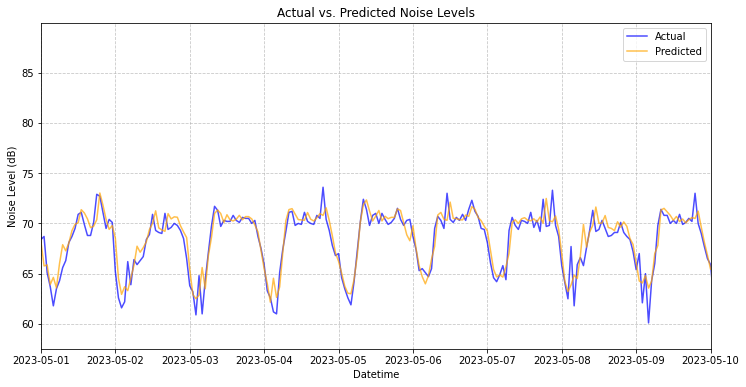

In [62]:
# Predict and evaluate
y_pred_optimized = optimized_model.predict(X_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
mape_optimized = mean_absolute_percentage_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print("\nOptimized Model Metrics:")
print(f"- MSE: {mse_optimized:.2f}")
print(f"- MAE: {mae_optimized:.2f}")
print(f"- MAPE: {mape_optimized:.2%}")
print(f"- R2: {r2_optimized:.2f}")

# Visualize actual vs. predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred_optimized, label='Predicted', color='orange', alpha=0.7)
plt.title('Actual vs. Predicted Noise Levels')
plt.xlabel('Datetime')
plt.ylabel('Noise Level (dB)')
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xlim(pd.to_datetime('2023-05-01'), pd.to_datetime('2023-05-10'))
plt.show()

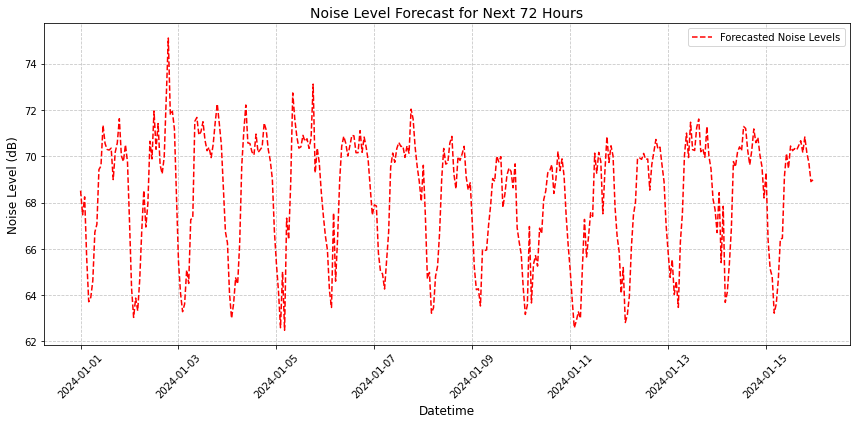

In [130]:
# Predict next 15 days
forecast_horizon = 24 * 15

# Combine X_train and X_test into a single DataFrame
X = pd.concat([X_train, X_test])
X.sort_index(inplace=True)

# Ensure that 'latest_data' includes only valid features
latest_data = X.tail(forecast_horizon)

# Predict future noise levels using the optimized model
future_forecast = optimized_model.predict(latest_data)

# Generate proper datetime index for the forecast
forecast_index = pd.date_range(start=X.index[-1], periods=forecast_horizon + 1, freq='H')[1:]

# Create a DataFrame for the forecast results
forecast_df = pd.DataFrame({'Forecasted_Noise': future_forecast}).set_index(forecast_index)

# Plot the forecasted results
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df, label='Forecasted Noise Levels', color='red', linestyle='--')
plt.title('Noise Level Forecast for Next 72 Hours', fontsize=14)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Noise Level (dB)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Overfitting?

In [131]:
# Evaluate the model on the training data
y_train_pred = optimized_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the model on the testing data
y_test_pred = optimized_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print("Training Data Metrics:")
print(f"- MSE: {mse_train:.2f}")
print(f"- MAE: {mae_train:.2f}")
print(f"- MAPE: {mape_train:.2%}")
print(f"- R^2: {r2_train:.2f}")

print("\nTesting Data Metrics:")
print(f"- MSE: {mse_test:.2f}")
print(f"- MAE: {mae_test:.2f}")
print(f"- MAPE: {mape_test:.2%}")
print(f"- R^2: {r2_test:.2f}")

Training Data Metrics:
- MSE: 2.06
- MAE: 0.96
- MAPE: 1.39%
- R^2: 0.82

Testing Data Metrics:
- MSE: 2.12
- MAE: 0.99
- MAPE: 1.46%
- R^2: 0.76


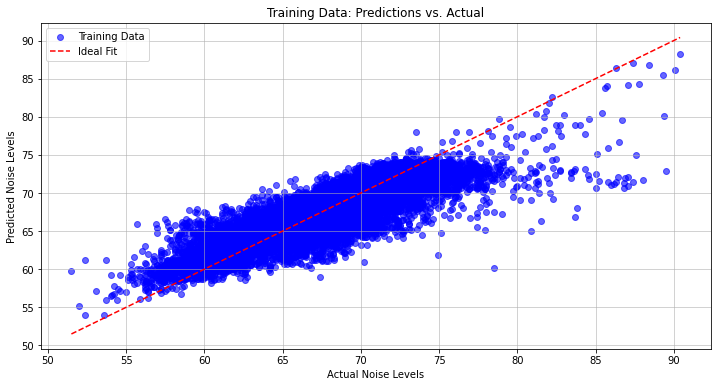

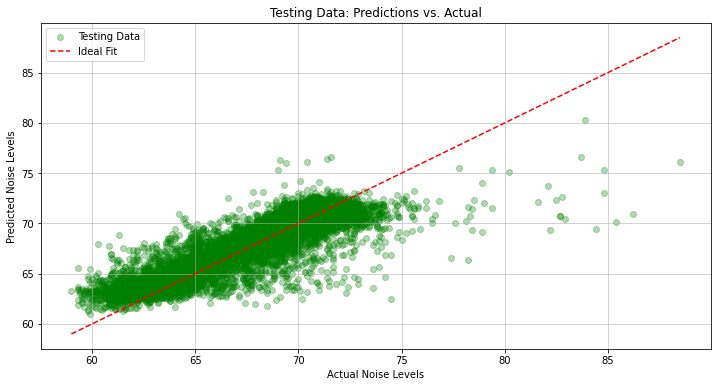

In [134]:
# Plot predictions vs. actual values for the training data
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, label='Training Data', alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Ideal Fit')
plt.title('Training Data: Predictions vs. Actual')
plt.xlabel('Actual Noise Levels')
plt.ylabel('Predicted Noise Levels')
plt.legend()
plt.grid(alpha=0.7)
plt.show()

# Plot predictions vs. actual values for the testing data
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, label='Testing Data', alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.title('Testing Data: Predictions vs. Actual')
plt.xlabel('Actual Noise Levels')
plt.ylabel('Predicted Noise Levels')
plt.legend()
plt.grid(alpha=0.7)
plt.show()

# Future Steps
* Hyperparameter tunining
* Handle anomalies due to lockdown period
* Model deployment for real time predictions
* Explore advanced models like LSTMs